## Lab 2: Classification
#### Danny Murphy, Kerry Nakayama, Brandon Tarr

#### Introduction
We've followed a very natural data evolution from Lab 1 where we first started reducing the dataset to a more manageable and relevant size by focusing on bookings only and a five class (rather than 100 class) classification task. In the mini lab we fine-tuned our imputation and started experimenting with logistic regression and SVM classification given the attributes that Expedia provided as well as a handful we created ourselves. Neither of these methods were particularly accurate (~36%) at classifying the targeted hotel cluster so now we turn to three new algorithms to attempt to raise our classification accuracy: AdaBoostClassifier, ExtraTreesClassifier, and RandomForestClassifier. These will also be used to attempt a regression exercise on booking_window (one of our added features) to see if we can predict when a user's ideal search window might be for more targeted solicitation.
#### Sources:
We make extensive use of the code provided for the Grand Poobah Classification Notebook for the class and code from Sebastian Raschka book "Python Machine Learning".

### Data Preparation
We will be conducting one classification task on the hotel cluster which has been the objective of this Kaggle dataset from the outset. This class variable is already in proper format as an integer representation of the five top hotel clusters [0]. All the other features are also in proper format, primarily as either integer representations of categorical variables [1:16] or as numeric continuous variables in either float or integer format [17:25].

#### New Variables
As a reminder, these variables were all added by our team to either contextualize the dates that Kaggle provided or to add more continuous variables in the hopes of adding more explanatory power to the model:

ci_week (check in week) = week of the year (1-52)
srch_week (week that the user's search was conducted) = week of the year (1-52)
family_size = adults + children
booking_window = check in date - search date (number of days booked prior to check in)
length_of_stay = check out date - check in date

In [101]:
#Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
# Reduced, imputed, file.
# Data can be downloaded here: https://www.dropbox.com/s/2vcqmorh3n3cm21/train_booked_top5_imputed.csv?dl=0
train_booked_df = pd.read_csv('data/train_booked_top5_imputed.csv')
train_booked_df.drop(['Unnamed: 0'], axis=1, inplace=True)

#### Dimensionality Reduction
We've attempted both logistic regression and SVM methods of classification with limited success using all the data that made sense to use without really doing much formal analysis of the utility of each feature. Now we'll spend some time investigating which features we might be able to eliminate to make our models more simple using Sequential Backward Selection (SBS) and random forest techniques.
#### Sequential Backward Selection
Sebastian Raschka's book provides this SBS algorithm code:

In [103]:
from sklearn.base import clone
from itertools import combinations
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

#### Sequential Backward Selection (Continued)
We are using the Logistic Regression model that we determined from the Mini-Lab to be most efficient while acheiving a consistent level of accuracy. While we understand that this model didn't produce good results, the purpose here is to see if we can't maintain the same level of accuracy with fewer features. To improve speed and performance we will be sampling down to around 30,000 records using a stratified shuffle split.

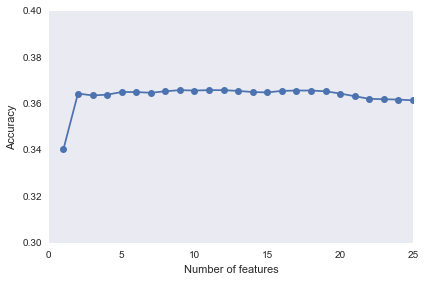

In [104]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

# we are sampling way down to improve performance (~30,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.015, train_size=0.06, random_state=0)

stdsc = StandardScaler()

for train_index, test_index in sss:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
lr = LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs')

# selecting features
sbs_lr = SBS(lr, k_features=1)
sbs_lr.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs_lr.subsets_]

plt.plot(k_feat, sbs_lr.scores_, marker='o')
plt.ylim([0.3, 0.4])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [105]:
# Display individual accuracy scores for each feature subset:
from sets import Set

print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_lr.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_lr.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_lr.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_lr.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.361432058584 , 25 , booking_window
 1) , 0.361757526444 , 24 , srch_children_cnt
 2) , 0.361920260374 , 23 , srch_adults_cnt
 3) , 0.362082994304 , 22 , hotel_market
 4) , 0.363222131814 , 21 , user_location_region
 5) , 0.364361269325 , 20 , site_name
 6) , 0.365337672905 , 19 , is_mobile
 7) , 0.365663140765 , 18 , is_booking
 8) , 0.365663140765 , 17 , cnt
 9) , 0.365500406835 , 16 , srch_rm_cnt
10) , 0.364849471115 , 15 , srch_destination_id
11) , 0.365012205045 , 14 , is_package
12) , 0.365500406835 , 13 , user_location_city
13) , 0.365825874695 , 12 , srch_destination_type_id
14) , 0.365825874695 , 11 , posa_continent
15) , 0.365663140765 , 10 , srch_week
16) , 0.365825874695 , 9 , user_location_country
17) , 0.365337672905 , 8 , family_size
18) , 0.364686737185 , 7 , channel
19) , 0.365012205045 , 6 , length_of_stay
20) , 0.365012205045 , 5 , ci_week
21) , 0.363873067535 , 4 , user_id
22) , 0.363547599675 ,

#### Important Features (LR):
We can see in the graph and the scores that a consistent level of accuracy (~36.5%) can be acheived with either 2 or 20 features with only slightly perceivable dips in between. The most important feature labels are hotel continenent and country followed by user id and distance between user and hotel. In the context of poor accuracy scores using logistic regression this tells us that this model is making a reasonable guess just by looking at the hotel continent with marginal gains made from the remainder of the features (pretty much any of them). We don't really like this accuracy or the underlying implications of these data. It makes logical sense that is_booking should lend no explanatory power to the model since we've already cleansed out all non-bookings. However, this feature is not the least important, that distinction going to hotel market instead. Looking at these features in this way helps us understand why logistic regression isn't the best model. Since we'll be moving away from logistic regression in the remainder of this lab, let's apply the same logic for feature importance but use random forests instead.

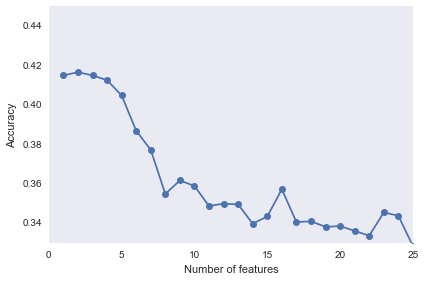

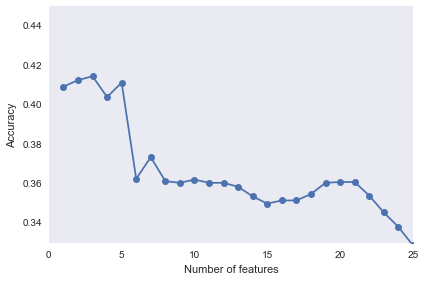

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# we are sampling way down to improve performance (~12,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.006, train_size=0.024, random_state=0)

dt_stump = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)

stdsc = StandardScaler()

for train_index, test_index in sss:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]

# Reduce # of estimators for efficiency during feature selection exercises.
rf = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

# selecting features
sbs_rf = SBS(rf, k_features=1)
sbs_rf.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat_rf = [len(k) for k in sbs_rf.subsets_]

# Reduce # of estimators for efficiency during feature selection exercises.
ada = AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R",
                       learning_rate=0.4, n_estimators=10)

# selecting features
sbs_ada = SBS(ada, k_features=1)
sbs_ada.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat_ada = [len(k) for k in sbs_ada.subsets_]

plt.plot(k_feat_rf, sbs_rf.scores_, marker='o')
plt.title('Random Forests SBS')
plt.ylim([0.33, 0.45])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

plt.plot(k_feat_ada, sbs_ada.scores_, marker='o')
plt.title('Adaboost SBS')
plt.ylim([0.33, 0.45])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [120]:
# Display individual accuracy scores for each feature subset:
from sets import Set

print("Random Forests SBS Feature Importances:")
print
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_rf.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_rf.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_rf.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_rf.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

Random Forests SBS Feature Importances:

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.328315703824 , 25 , cnt
 1) , 0.343775427177 , 24 , hotel_continent
 2) , 0.345402766477 , 23 , srch_children_cnt
 3) , 0.33360455655 , 22 , booking_window
 4) , 0.3360455655 , 21 , channel
 5) , 0.338486574451 , 20 , user_id
 6) , 0.338079739626 , 19 , is_booking
 7) , 0.340927583401 , 18 , user_location_country
 8) , 0.340520748576 , 17 , site_name
 9) , 0.357200976404 , 16 , ci_week
10) , 0.343368592352 , 15 , srch_adults_cnt
11) , 0.339707078926 , 14 , srch_rm_cnt
12) , 0.349471114727 , 13 , srch_week
13) , 0.349877949552 , 12 , srch_destination_type_id
14) , 0.348657445077 , 11 , user_location_city
15) , 0.358828315704 , 10 , user_location_region
16) , 0.361676159479 , 9 , length_of_stay
17) , 0.354759967453 , 8 , orig_destination_distance
18) , 0.377135882832 , 7 , family_size
19) , 0.386899918633 , 6 , is_mobile
20) , 0.404800650936 , 5 , posa_continent
21) , 0.41253

In [121]:
# Display individual accuracy scores for each feature subset:
print("Adaboost SBS Feature Importances:")
print
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_ada.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_ada.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_ada.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_ada.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

Adaboost SBS Feature Importances:

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.328722538649 , 25 , user_id
 1) , 0.338079739626 , 24 , user_location_city
 2) , 0.345402766477 , 23 , ci_week
 3) , 0.353946297803 , 22 , is_package
 4) , 0.360862489829 , 21 , cnt
 5) , 0.360862489829 , 20 , srch_children_cnt
 6) , 0.360455655004 , 19 , srch_rm_cnt
 7) , 0.354759967453 , 18 , is_booking
 8) , 0.351505288853 , 17 , srch_adults_cnt
 9) , 0.351505288853 , 16 , user_location_region
10) , 0.349877949552 , 15 , family_size
11) , 0.353539462978 , 14 , user_location_country
12) , 0.358421480879 , 13 , srch_destination_type_id
13) , 0.360455655004 , 12 , posa_continent
14) , 0.360455655004 , 11 , channel
15) , 0.362082994304 , 10 , srch_week
16) , 0.360455655004 , 9 , booking_window
17) , 0.361269324654 , 8 , hotel_continent
18) , 0.373474369406 , 7 , length_of_stay
19) , 0.362489829129 , 6 , orig_destination_distance
20) , 0.411310008137 , 5 , is_mobile
21) , 0.4039869

#### Important Features (RF):
We can see in the graph and the scores that the best accuracy results come from including between 1-4 features. 
#### Sequential Backward Selection Conclusions:
In the context of logistic regression which we're familiar with from the Mini-Lab, it doesn't seem to influence accuracy much beyond using the hotel continent, country, distance between user and hotel, and length of stay. One could even argue that just continent and country are enough although the test fit does improve with four features. Random Forest SBS also settles on 4 feature as important, although they are only sometimes similar to the 4 important features identified with logistic regression. What seems to be clear is that some hotel location feature (continent, country, market) are important. Since SBS results bounce around through several iterations we want to explore built-in functions in the Random Forest algorithm before deciding to exclude variables.
#### Random Forest feature selection:
Since we will be using a couple of variations of random forest algorithms in our classification task let's see what this algorithm's feature_importances function determines to have explanatory power:

 1) hotel_market                   0.107868
 2) srch_destination_id            0.102026
 3) orig_destination_distance      0.097856
 4) user_id                        0.093783
 5) user_location_city             0.087022
 6) srch_week                      0.074021
 7) ci_week                        0.072787
 8) booking_window                 0.071516
 9) user_location_region           0.065946
10) channel                        0.031236
11) length_of_stay                 0.029644
12) hotel_country                  0.025501
13) hotel_continent                0.023168
14) family_size                    0.020228
15) srch_adults_cnt                0.016330
16) srch_destination_type_id       0.016299
17) user_location_country          0.013750
18) site_name                      0.011180
19) srch_children_cnt              0.011137
20) is_mobile                      0.009880
21) srch_rm_cnt                    0.008252
22) posa_continent                 0.004415
23) is_package                  

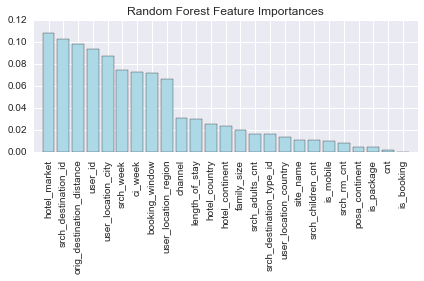

In [114]:
feat_labels = train_booked_df.columns[1:]

rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)

rf.fit(X, y)
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Random Forest Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

#### Random Forest Feature Importances:
This interpretation makes more sense from the outset. First we're directed toward our litmus test variable is_booking which turns out to have no explanatory power as we would expect. Good start. We end up with 9 features that make up 77.3% of our feature importance in our model. We'll save this feature subset in a new dataframe randomforest_df1.

 1) hotel_market                   0.108969
 2) user_location_city             0.106455
 3) user_location_region           0.100877
 4) booking_window                 0.084865
 5) ci_week                        0.083917
 6) srch_destination_id            0.080048
 7) srch_week                      0.078335
 8) user_id                        0.070559
 9) user_location_country          0.052413
10) hotel_continent                0.043815
11) length_of_stay                 0.042488
12) orig_destination_distance      0.030235
13) hotel_country                  0.029709
14) channel                        0.016506
15) family_size                    0.015698
16) posa_continent                 0.011293
17) srch_children_cnt              0.010749
18) srch_destination_type_id       0.010269
19) site_name                      0.008092
20) srch_adults_cnt                0.005828
21) srch_rm_cnt                    0.005000
22) is_mobile                      0.002285
23) is_package                  

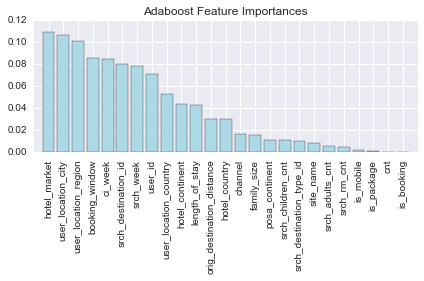

In [113]:
feat_labels = train_booked_df.columns[1:]


ada = AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R",
                       learning_rate=0.4, n_estimators=10)

ada.fit(X, y)
importances = ada.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Adaboost Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./ada.png', dpi=300)
plt.show()

In [135]:
# Both Random Forest and Adaboost show is_booking and cnt to be unimportant.
train_booked_df.drop(['is_booking','cnt'], axis=1, inplace=True)

#### Feature Selection Conclusions:
We've been able to learn a lot about how different features impact our models in general, and which have specific impacts to each individual algorithm. We now take these findings and create a variety of feature subset dataframes that we can continue to experiment with throughout the rest of this analysis:
#### Random Forest Dataframes:

In [136]:
# Create reduced df based on most important features from the random forest important features function:
randomforest_df1 = train_booked_df[['hotel_cluster','hotel_market','srch_destination_id','orig_destination_distance',
                            'user_id','user_location_city','srch_week','ci_week','booking_window',
                            'user_location_region']]

Finally, let's create a hybrid feature subset composed of the 4 features from SBS and the feature importances using random forest with a threshold of >0.8%.

In [137]:
# These features yielded the best performance in SBS:
randomforest_df2 = train_booked_df[['hotel_cluster','hotel_market','srch_destination_id','orig_destination_distance',
                            'user_id','user_location_city','hotel_continent','hotel_country']]

#### Adaboost Dataframes:

In [138]:
# Create reduced df based on important features:
adaboost_df1 = train_booked_df[['hotel_market','user_location_city','user_location_region','booking_window','ci_week',
                                    'srch_destination_id','srch_week','user_id','user_location_country',
                                    'hotel_continent','length_of_stay','orig_destination_distance','hotel_country']]

### Modeling and Evaluation
#### Evaluation Metrics
For our evaluation metric we are using the accuracy in order to help us decide which is the best model to choose. We are using a classification model distinguish which features will build the best model for picking the correct cluster.  Since the clusters are masked we do not care to actually classify each of the varibles into one cluster or another but rather did we choose the correct cluster or not.  So in this case the accuracy of our score will let us know how well we created a model that predicted which cluster is choosen.  
Many times it is said that accuarcy is not enough that we should also look at false positive and false negatives.  In this scenario it is most important to us to get a model that is most accurate.  Presicison and recall would give us the true positves divided by the false positves and true postives divided by the false negative respectively however in this model of choosing the hotel cluster it does not hurt us like it might in a cancer study of giving someone a false postive.  In order to win the kaggle competition we are trying to find the model that best predicts the most true postives which is ultimately give to us through accuracy. 
#### Training/Testing Split Strategy
All 3 of the machine learning algorithms we are using are quite computationally expensive on 400,000 records. Based on this fact we are sampling way down to improve performance by taking approximately 40,000 records. We're using stratified shuffle split to easily sub-sample by our class proportions even though we don't really care about the test data since we'll be using stratified k-fold next. We did a series of tests plotted in the following graph which show
#### Modeling: Classification Task
Once again we are 

In [129]:
# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

# feature subsets:
X1, y1 = randomforest_df1.iloc[:, 1:].values, randomforest_df1.iloc[:, 0].values
X2, y2 = randomforest_df2.iloc[:, 1:].values, randomforest_df2.iloc[:, 0].values

# This takes a stratified sample of 10% of our total dataset:
cv_object = StratifiedShuffleSplit(y, n_iter=1, test_size=0.001, train_size=0.099)
cv_object1 = StratifiedShuffleSplit(y1, n_iter=1, test_size=0.001, train_size=0.099)
cv_object2 = StratifiedShuffleSplit(y2, n_iter=1, test_size=0.001, train_size=0.099)

stdsc = StandardScaler()
  
# Now we
for train_index, test_index in cv_object:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
for train_index, test_index in cv_object1:
    X_train_std1, X_test_std1 = stdsc.fit_transform(X1[train_index]), stdsc.fit_transform(X1[test_index])
    y_train1, y_test1 = y1[train_index], y1[test_index]
    
for train_index, test_index in cv_object2:
    X_train_std2, X_test_std2 = stdsc.fit_transform(X2[train_index]), stdsc.fit_transform(X2[test_index])
    y_train2, y_test2 = y2[train_index], y2[test_index]

#### Parameter optimization
This section documents the trial and error that helped us arrive at an optimized model for random forests:

In [127]:
from sklearn.cross_validation import StratifiedKFold

# create variables we are more familiar with
X, y = X_train_std, y_train
yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y, n_folds=10)

# The following code documents my experimentation with several different random forest parameters:
# The Accuracy for each parameter combination is listed below each instance.

#clf = RandomForestClassifier(max_depth=5, n_estimators=50)
# Accuracy 0.371072319202

# clf = RandomForestClassifier(max_depth=10, n_estimators=50)
# Accuracy 0.368578553616

# clf = RandomForestClassifier(max_depth=25, n_estimators=50)
# Accuracy 0.35710723192

# clf = RandomForestClassifier(max_depth=50, n_estimators=50)
# Accuracy 0.346882793017

# clf = RandomForestClassifier(max_depth=5, n_estimators=50)
# Accuracy 0.372817955112

# clf = RandomForestClassifier(max_depth=5, n_estimators=5)
# Accuracy 0.366583541147

#clf = RandomForestClassifier(max_depth=5, n_estimators=10)
# Accuracy 0.375546739904

#clf = RandomForestClassifier(max_depth=5, n_estimators=25)
# Accuracy 0.374984117365

# clf = RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=-1, oob_score=True)
# Accuracy 0.378170418226

# clf = RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=-1, oob_score=True, class_weight='balanced')
# Accuracy 0.369134420846

# clf = RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1, oob_score=True, 
#                              class_weight='balanced_subsample', min_weight_fraction_leaf=0.1)
# Accuracy 0.345447303862

# The class_weight balanced_subsample outperforms balanced or the default 'none'
# clf = RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1, oob_score=True, 
#                              class_weight='balanced_subsample')
# Accuracy 0.448088219483

# clf = RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1, oob_score=True, 
#                              class_weight='balanced')
# Accuracy 0.447785227684


# the entropy criteria works slightly better than the default "gini".
clf = RandomForestClassifier(max_depth=20, n_estimators=20, criterion='entropy', n_jobs=-1, oob_score=True, 
                             class_weight='balanced_subsample')
# Accuracy 0.449588517588

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Accuracy', total_accuracy


Accuracy 0.448198176185


#### Model performance after optimization:
Just through model parameter changes we've been able to improve our accuracy score by 8% over anything using logistic regression or SVM in the MiniLab, and improve 3-4% over the highest accuracies seen in the feature analysis. But this is on the full dataset. We would expect the feature subsets to perform even better on data containing the most important features.
#### Random Forest Important Features:

In [131]:
# create variables we are more familiar with
X, y = X_train_std1, y_train1

yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y, n_folds=10)

# the entropy criteria works slightly better than the default "gini".
clf = RandomForestClassifier(max_depth=20, n_estimators=20, criterion='entropy', n_jobs=-1, oob_score=True, 
                             class_weight='balanced_subsample')

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Accuracy', total_accuracy


Accuracy 0.488992112439


By just focusing on the features that make up 77.3% of feature importance based on the random forest feature importance function we've added another 3-4% to our accuracy.
#### Random Forest & SBS Important Features:

In [132]:
# create variables we are more familiar with
X, y = X_train_std2, y_train2

yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y, n_folds=10)

# the entropy criteria works slightly better than the default "gini".
clf = RandomForestClassifier(max_depth=20, n_estimators=20, criterion='entropy', n_jobs=-1, oob_score=True, 
                             class_weight='balanced_subsample')

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Accuracy', total_accuracy


Accuracy 0.504728138164


#### Analysis: Classification Task

In [68]:
freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print 'Total Accuracy:',total_accuracy
print 'Number of infrequent faces:',len(recall_for_freq_classes), 'with average recall of:', np.mean(recall_for_freq_classes)
print 'Number of frequent faces:',len(prec_for_freq_classes), 'with average precision of:',np.mean(prec_for_freq_classes)

Total Accuracy: 0.447785227684
Number of infrequent faces:

NameError: name 'recall_for_freq_classes' is not defined

#### Statistics and Model Advantages: Classification Task
#### Attribute Assessment: Classification Task
#### Modeling: Regression Task
#### Analysis: Regression Task
#### Statistics and Model Advantages: Regression Task
#### Attribute Assessment: Regression Task


### Deployment

### Exceptional Work